## Preprocessing of textual data

In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# charger le corpus de données

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file = '/content/drive/MyDrive/sample-data.csv'

In [4]:
data = pd.read_csv(file)

data.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS

In [6]:
print(data.columns)

Index(['id', 'description'], dtype='object')


##Partie 1 : Groupes de produits avec des descriptions similaires

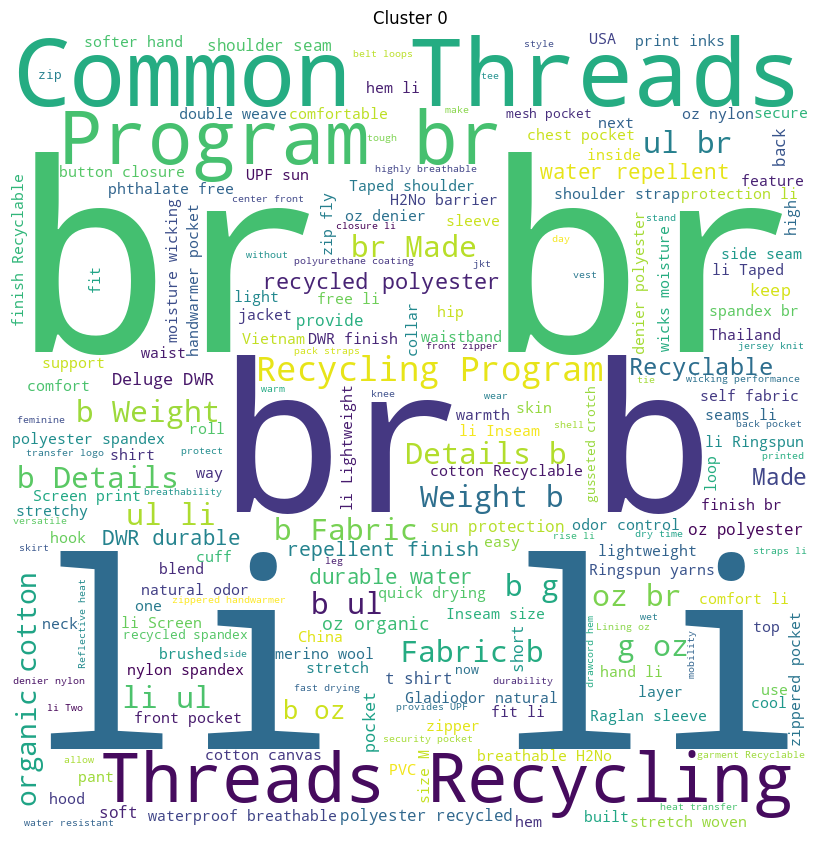

In [8]:
import matplotlib.pyplot as plt
# Créer une matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['description'])

# Calculer la matrice de similarité cosinus entre les vecteurs de description
cosine_sim_matrix = cosine_similarity(tfidf)

# Former le modèle DBSCAN
dbscan = DBSCAN(metric='precomputed', eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(cosine_sim_matrix)
data['cluster'] = clusters

# Afficher les nuages de mots pour chaque cluster
stopwords = set(STOPWORDS)
for cluster_id in set(clusters):
    if cluster_id == -1:
        continue
    cluster_docs = data[data['cluster'] == cluster_id]['description'].tolist()
    cluster_text = ' '.join(cluster_docs)
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(cluster_text)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'Cluster {cluster_id}')
    plt.show()

## Partie 2 - Système de recommandation

In [9]:
# Fonction pour générer un nuage de mots
def generate_wordcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=800, height=800, 
                    background_color='white',
                    stopwords=stopwords,
                    min_font_size=10).generate(text)
    return wordcloud

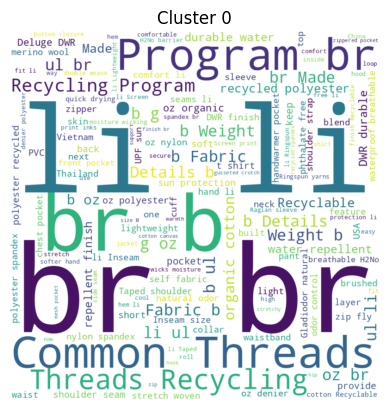

In [10]:
# Afficher un nuage de mots pour chaque cluster
for cluster_id in set(clusters):
    if cluster_id == -1:
        continue
    cluster_docs = data[data['cluster'] == cluster_id]['description'].tolist()
    cluster_text = ' '.join(cluster_docs)
    wordcloud = generate_wordcloud(cluster_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Cluster {cluster_id}')
    plt.show()

In [11]:
# Demander à l'utilisateur de saisir l'ID d'un produit
product_id = input('Entrez l\'identifiant du produit qui vous intéresse: ')

Entrez l'identifiant du produit qui vous intéresse: 100


In [12]:
# vérifier si la clé existe avant de l'utiliser
if '1' in data.index:
    row = data.loc['0']
else:
    print("La clé '0' n'existe pas dans l'index du dataframe")

La clé '0' n'existe pas dans l'index du dataframe


In [13]:
print(data.index)

RangeIndex(start=0, stop=500, step=1)


In [14]:
product_id = input("Entrez l'identifiant du produit : ")
if int(product_id) in data.index:
    print("L'identifiant de produit saisi est présent dans l'index.")
else:
    print("L'identifiant de produit saisi n'est pas présent dans l'index.")

Entrez l'identifiant du produit : 400
L'identifiant de produit saisi est présent dans l'index.


In [15]:
# Saisie de l'identifiant du produit
product_id = input("Entrez l'identifiant du produit : ")

# Vérification si l'identifiant du produit existe dans notre dataframe
if int(product_id) not in data.index:
    print("L'identifiant du produit saisi n'existe pas.")
else:
    # Récupération du cluster auquel appartient le produit
    cluster_id = data.loc[int(product_id), 'cluster']
    
    # Récupération des produits appartenant au même cluster que le produit saisi
    similar_products = data[data['cluster'] == cluster_id]
    
    # Affichage des produits similaires
    print(f"Les produits similaires pour le produit {product_id} sont :")
    for index, row in similar_products.iterrows():
        if index != int(product_id):
            print(f"- Produit {index} : {row['description']}")

Entrez l'identifiant du produit : 400
Les produits similaires pour le produit 400 sont :
- Produit 0 : Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garme

##Partie 3 : Modélisation du sujet

In [17]:
from sklearn.decomposition import TruncatedSVD
# Entraînement du modèle TruncatedSVD
n_components = 5
svd_model = TruncatedSVD(n_components=n_components)
svd_model.fit(tfidf)

TruncatedSVD(n_components=5)

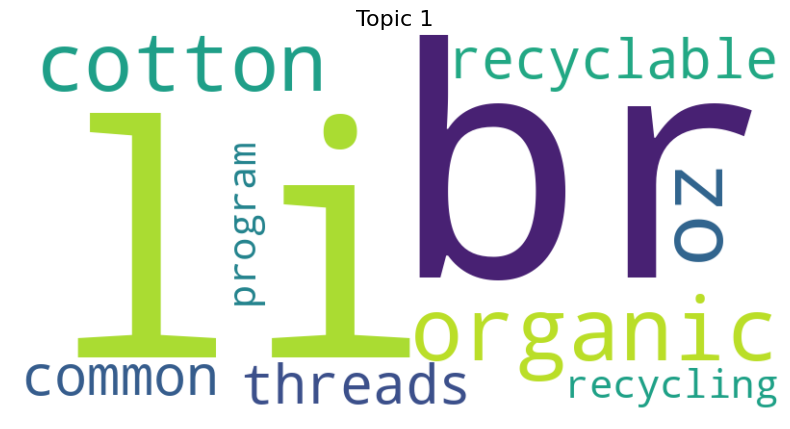

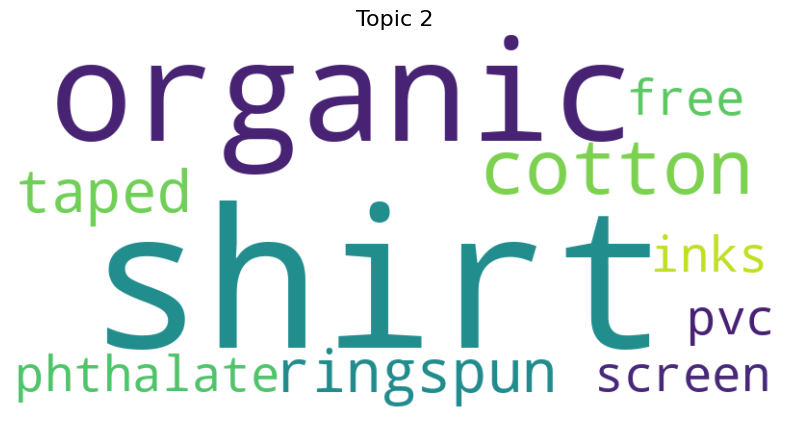

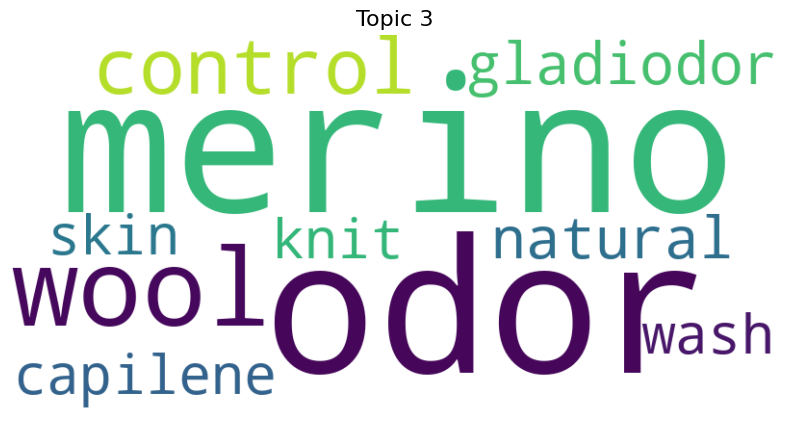

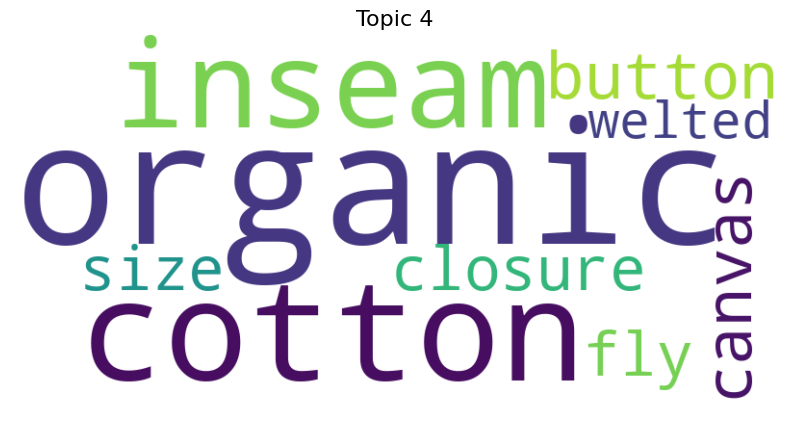

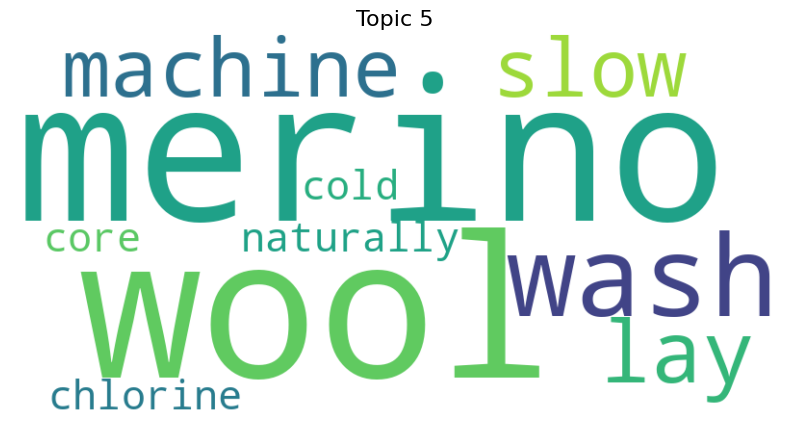

In [18]:
n_components = 5
svd_model = TruncatedSVD(n_components=n_components)
svd_model.fit(tfidf)
 
for i in range(n_components):
    top_words_indices = svd_model.components_[i].argsort()[::-1][:10]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i+1}', fontsize=16)
    plt.show()

Le code utilise la méthode TruncatedSVD de la bibliothèque scikit-learn pour effectuer une analyse sémantique latente sur un corpus de texte. Il utilise un modèle TF-IDF pour convertir le texte en vecteurs de features, puis applique l'algorithme TruncatedSVD pour réduire la dimensionnalité des données. Enfin, il affiche des nuages de mots pour les mots les plus représentatifs de chaque sujet latent identifié par le modèle TruncatedSVD.